In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [3]:
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths=['/mnt/c/Windows/Fonts', '/mnt/c/Users/trommer/AppData/Local/Microsoft/Windows/Fonts'], fontext='otf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Neue Haas Grotesk Text Pro'
# mpl.rcParams['font.family'] = 'Linux Biolinum'
mpl.rcParams['font.family'] = 'CMU Sans Serif'

plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True

colors = sns.color_palette('Set2')

In [4]:
def read_results(path):
    with open(path, 'r') as f:
        data = json.load(f)
    benchmarks = data['benchmarks']

    res = []
    for b in benchmarks:
        flat_dict = {**b['params'], **b['stats']}
        res.append(flat_dict)

    df = pd.DataFrame.from_records(res)
    b_name = os.path.basename(path)
    f_name, _ = os.path.splitext(b_name)
    df['filename'] = f_name
    return df

In [17]:
ta = read_results('benchmark_results/torchapprox_conv_layer.json')
tf = read_results('benchmark_results/tfapprox_conv_layer.json')
df = pd.concat([ta, tf], ignore_index=True).sort_values(['channels', 'model'], ignore_index=True)
df = df.loc[df.channels > 1]
df = df.loc[df.model != 'mul8s_1KV8']
df = df.loc[df.model != 'mul8s_1L2D']
df.loc[df.filename == 'tfapprox_conv_layer', 'model'] = 'tfapprox'

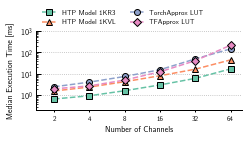

In [20]:
sns.set_palette('Set2')
fig = plt.figure(figsize=(3.5,2.2))
ax = fig.add_subplot(111)


# ax.yaxis.set_tick_params(which='minor', size=2, width=0.75)

params = [
    ('mul8s_1KR3', 'HTP Model 1KR3', 's'),
    ('mul8s_1KVL', 'HTP Model 1KVL', '^'),
    ('lut','TorchApprox LUT', 'o'),
    ('tfapprox', 'TFApprox LUT', 'D'),
]
for key, name, marker in params:
    models = df[df.model == key]
    plt.plot(models.channels, models['median'] * 1000, label=name, marker=marker, linestyle='--', markeredgecolor='black')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of Channels')
ax.set_ylabel('Median Execution Time [ms]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(np.unique(df.channels))
ax.set_xticklabels(np.unique(df.channels), fontsize=7)
ax.xaxis.set_tick_params(which='major', size=2, width=1)
ax.xaxis.set_tick_params(which='minor', bottom=False)

ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='in')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='in')
ax.yaxis.grid(linestyle='dotted')
ax.set_ylim(2e-1, 1e3)
ax.set_xlim(1.4, 80)

ax.legend(ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.35), fontsize=7)
plt.tight_layout()
plt.savefig('conv2d_benchmark.pdf', bbox_inches='tight')
plt.show()
    

In [91]:
vals = df[df.model == 'tfapprox']['median'] / df[df.model == 'mul8s_1KR3']['median'].values
gmean(vals)

4.598452159165112

In [7]:
pretty_names = {
    'alexnet' : 'AlexNet',
    'effcientnet_b0' : 'EfficientNetB0',
    'mobilenet_v2' : 'MobileNetV2',
    'resnet18' : 'ResNet18',
    'resnet50' : 'ResNet50',
    'vgg16' : 'VGG16',
}
df = read_results('benchmark_results/desktop.json')
df.loc[df.bench_type.isna(), 'bench_type'] = 'adaPT'
df.bench_architecture = df.bench_architecture.map(pretty_names)
df.sort_values(['bench_architecture', 'bench_type'], inplace=True, ignore_index=True)

In [8]:
print((df[df.bench_type == 'adaPT']['median'] / df[df.bench_type == 'mul8s_1KVL']['median'].values).min())
print((df[df.bench_type == 'adaPT']['median'] / df[df.bench_type == 'mul8s_1KR3']['median'].values).max())
print((df[df.bench_type == 'lut']['median'] / df[df.bench_type == 'mul8s_1KVL']['median'].values).min())
print((df[df.bench_type == 'lut']['median'] / df[df.bench_type == 'mul8s_1KR3']['median'].values).max())

27.109077752769238
245.1099773746799
0.8437631586845804
12.310769937503693


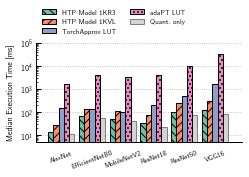

In [16]:
params = [
    # ('mul8s_1L2D', 'HTP Model 1L2D', '///'),
    ('mul8s_1KR3', 'HTP Model 1KR3', '\\\\\\'),
    ('mul8s_1KVL', 'HTP Model 1KVL', '///'),
    ('lut', 'TorchApprox LUT', None),
    ('adaPT', 'adaPT LUT', '...'),
    ('baseline', 'Quant. only', None),
]

width = 0.85/len(params)

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.add_subplot(111)



for i, (key, label, hatch) in enumerate(params):
    ans = df[df.bench_type == key]
    x = np.arange(len(ans)) + i*width
    if key == 'baseline':
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='grey', color = 'lightgrey', label=label, zorder=1)
    else:
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='black', hatch=hatch, label=label, zorder=2)

labels = np.unique(df.bench_architecture)
ax.xaxis.set_ticks(np.arange(len(labels)) + len(params)/2 * width, labels, rotation=20, size=7)
ax.xaxis.set_tick_params(bottom=False)
ax.set_xlim(-0.4, len(params)+1.3)

ax.set_yscale('log')
ax.set_ylabel('Median Execution Time [ms]')
ax.set_ylim(5, 1e5)
ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='in')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='in')
ax.yaxis.grid(which='major', linestyle='dotted')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.40), fontsize=7)

plt.tight_layout()
plt.savefig('network_benchmark.pdf', bbox_inches='tight')
plt.show() 

In [83]:
from scipy.stats import gmean

vals = df[df.bench_type == 'adaPT']['median']/df[df.bench_type == 'mul8s_1KR3']['median'].values
gmean(vals)
# vals

103.37805668605023

In [74]:
df

,bench_architecture,min,max,mean,stddev,rounds,median,iqr,q1,q3,iqr_outliers,stddev_outliers,outliers,ld15iqr,hd15iqr,ops,total,iterations,bench_type,filename
0,AlexNet,1.571743,1.818492,1.634295,0.050299,50,1.622610,0.052140,1.595001,1.647141,3,9,9;3,1.571743,1.743919,0.611885,81.714759,1,adaPT,desktop
1,AlexNet,0.011396,0.011482,0.011437,0.000014,82,0.011435,0.000014,0.011429,0.011443,5,19,19;5,0.011410,0.011466,87.436139,0.937827,1,baseline,desktop
2,AlexNet,0.158651,0.160706,0.160125,0.000541,50,0.160258,0.000450,0.160081,0.160531,8,10,10;8,0.159420,0.160706,6.245126,8.006243,1,lut,desktop
3,AlexNet,0.013831,0.014059,0.013884,0.000026,69,0.013880,0.000017,0.013874,0.013891,2,7,7;2,0.013854,0.014059,72.023068,0.958026,1,mul8s_1KR3,desktop
4,AlexNet,0.027497,0.027591,0.027547,0.000020,50,0.027544,0.000026,0.027537,0.027563,1,11,11;1,0.027503,0.027591,36.301028,1.377371,1,mul8s_1KVL,desktop
5,AlexNet,0.022065,0.022187,0.022124,0.000024,50,0.022121,0.000037,0.022103,0.022141,0,16,16;0,0.022065,0.022187,45.200461,1.106183,1,mul8s_1L2D,desktop
6,EfficientNetB0,3.857319,4.733618,3.951686,0.157242,50,3.923460,0.053013,3.894216,3.947229,2,2,2;2,3.857319,4.659593,0.253057,197.584298,1,adaPT,desktop
7,EfficientNetB0,0.054993,0.059197,0.055300,0.000776,50,0.055091,0.000062,0.055070,0.055132,7,2,2;7,0.054993,0.055515,18.083043,2.765021,1,baseline,desktop
8,EfficientNetB0,0.132184,0.149536,0.132793,0.002419,50,0.132436,0.000068,0.132407,0.132475,7,1,1;7,0.132324,0.132585,7.530493,6.639672,1,lut,desktop
9,EfficientNetB0,0.068324,0.074816,0.068607,0.000979,50,0.068392,0.000058,0.068371,0.068429,8,2,2;8,0.068324,0.068542,14.575728,3.430360,1,mul8s_1KR3,desktop
